In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# подключение к базе

con = sqlite3.connect('linkedin.db', timeout=10)
cur = con.cursor()

In [57]:
# чтение данных из CSV 

benefits_df = pd.read_csv('benefits.csv')
companies_df = pd.read_csv('companies.csv')
company_industries_df = pd.read_csv('company_industries.csv')
company_specialities_df = pd.read_csv('company_specialities.csv')
employee_counts_df = pd.read_csv('employee_counts.csv')
job_industries_df = pd.read_csv('job_industries.csv')
job_postings_df = pd.read_csv('job_postings.csv')
job_skills_df = pd.read_csv('job_skills.csv')

In [58]:
# удаление дубликатов

benefits_df = benefits_df.drop_duplicates(keep='first', inplace=False, ignore_index=False)
companies_df = companies_df.drop_duplicates(keep='first', inplace=False, ignore_index=False)
company_industries_df = company_industries_df.drop_duplicates(keep='first', inplace=False, ignore_index=False)
company_specialities_df = company_specialities_df.drop_duplicates(keep='first', inplace=False, ignore_index=False)
employee_counts_df = employee_counts_df.drop_duplicates(keep='first', inplace=False, ignore_index=False)
job_industries_df = job_industries_df.drop_duplicates(keep='first', inplace=False, ignore_index=False)
job_postings_df = job_postings_df.drop_duplicates(keep='first', inplace=False, ignore_index=False)
job_skills_df = job_skills_df.drop_duplicates(keep='first', inplace=False, ignore_index=False)

In [59]:
# удаление лишних столбцов

benefits_df = benefits_df.drop(columns = ['inferred'])
employee_counts_df = employee_counts_df.drop(columns = ['follower_count', 'time_recorded'])
companies_df = companies_df.drop(columns=['zip_code', 'url', 'address'])
job_postings_df = job_postings_df.drop(columns=['currency','applies','original_listed_time',
                                                'views','job_posting_url','application_url','application_type',
                                                'expiry','closed_time','listed_time','posting_domain','sponsored',
                                                'work_type','compensation_type'])
job_postings_df = job_postings_df.dropna(subset=['company_id'])

In [60]:
# объединение данных по вакансиям, компаниям, сферам деятельности и численности сотрудников

companies_df = companies_df.merge(company_industries_df, on='company_id')
companies_df = companies_df.merge(employee_counts_df, on='company_id')
job_postings_df = job_postings_df.merge(companies_df, on='company_id')

In [61]:
# приведение ЗП

job_postings_df['normalized_salary'] = job_postings_df.apply(
    lambda x: (x['max_salary']+x['min_salary'])/2 if not pd.isnull(x['max_salary']) else x['med_salary'], axis=1)

period = {'HOURLY': 40*52, 'MONTHLY': 12, 'YEARLY': 1}

job_postings_df['normalized_salary'] = job_postings_df.apply(
    lambda x: period[x['pay_period']] * x['normalized_salary']
    if not pd.isna(x['pay_period']) and not pd.isna(x['normalized_salary'])
    else np.nan,
    axis=1
)

In [63]:
job_postings_df = job_postings_df.drop_duplicates(keep='first', inplace=False, ignore_index=False)
job_postings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17160 entries, 0 to 139889
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   job_id                      17160 non-null  int64  
 1   company_id                  17160 non-null  float64
 2   title                       17160 non-null  object 
 3   description_x               17159 non-null  object 
 4   max_salary                  6026 non-null   float64
 5   med_salary                  1056 non-null   float64
 6   min_salary                  6026 non-null   float64
 7   pay_period                  7082 non-null   object 
 8   formatted_work_type         17160 non-null  object 
 9   location                    17160 non-null  object 
 10  remote_allowed              2501 non-null   float64
 11  formatted_experience_level  12240 non-null  object 
 12  skills_desc                 145 non-null    object 
 13  name                        17160 n

In [64]:
# загрузка данных в БД

benefits_df.to_sql(con=con, name='benefits', index=False, if_exists = 'replace')
company_specialities_df.to_sql(con=con, name='company_specialities', index=False, if_exists = 'replace')
job_postings_df.to_sql(con=con, name='job_postings', index=False, if_exists = 'replace')
job_skills_df.to_sql(con=con, name='job_skills', index=False, if_exists = 'replace')

27899

In [52]:
# ТОП 10 компаний по опубликованным вакансиям

# top_companies = job_postings_df['name'].value_counts().head(10)
job_postings_df['name'].value_counts().head(10)

name
Google                          186
City Lifestyle                  161
H&R Block                       156
Verizon                         113
Robert Half                     112
Insight Global                  108
Amazon                           93
The Mom Project                  92
Ulta Beauty                      86
Milestone Technologies, Inc.     74
Name: count, dtype: int64

In [53]:
# частота предложения бонусов

benefits_df['type'].value_counts().head(20)

type
401(k)                     4426
Medical insurance          2065
Vision insurance           1989
Dental insurance           1611
Disability insurance       1468
Tuition assistance          598
Commuter benefits           427
Paid maternity leave        417
Paid paternity leave        394
Pension plan                237
Student loan assistance      67
Child care support           62
Name: count, dtype: int64

In [65]:
# ТОП-10 наиболее оплачиваемых сфер деятельности компаний 

job_postings_df.groupby('industry')['normalized_salary'].median().sort_values(ascending=False).head(10)

industry
Online Media                        300000.0
Veterinary                          275000.0
Investment Banking                  205000.0
Publishing                          201182.0
Public Policy                       185810.0
Computer Software                   155575.0
Venture Capital & Private Equity    150000.0
Consumer Electronics                149250.0
Fine Art                            144000.0
Executive Office                    141000.0
Name: normalized_salary, dtype: float64

In [16]:
# ТОП востребованных навыков

job_skills_df.groupby('skill_abr')['job_id'].count().sort_values(ascending=False).head(10)


skill_abr
IT      3841
SALE    2904
MGMT    2467
MNFC    2195
BD      1993
ENG     1974
OTHR    1574
HCPR    1346
FIN     1227
ACCT     813
Name: job_id, dtype: int64

In [37]:
# ТОП компаний с наибольшим предложением ЗП

job_postings_df.groupby('name')['normalized_salary'].median().sort_values(ascending=False).head(10)

name
UP Talent Group                800000.0
ICON Strategic Solutions       750000.0
Baylor Scott & White Health    750000.0
Selby Jennings                 650000.0
Harris County                  564213.0
Goliath Partners               425000.0
Summit Funding, Inc.           362500.0
Niantic, Inc.                  317500.0
Acrisure                       317500.0
Rambus                         315000.0
Name: normalized_salary, dtype: float64

In [105]:
# ТОП индустрий по опубликованным вакансиям 

top_ind_vac = job_postings_df.groupby('industry')['job_id'].count().sort_values(ascending=False).head(10)
top_ind_vac

industry
Staffing & Recruiting                2537
Information Technology & Services    1974
Hospital & Health Care               1586
Retail                               1235
Computer Software                    1007
Financial Services                    606
Transportation/Trucking/Railroad      350
Construction                          324
Real Estate                           316
Insurance                             278
Name: job_id, dtype: int64

In [75]:
# распределение по типу занятости

job_postings_df.groupby('formatted_work_type')['job_id'].count().sort_values(ascending=False).head(10)

formatted_work_type
Full-time     13867
Contract       1875
Part-time      1095
Temporary       136
Internship      118
Other            62
Volunteer         7
Name: job_id, dtype: int64

In [135]:
# по возможности удаленной работы

job_postings_df.groupby('formatted_work_type')['remote_allowed'].count().sort_values(ascending=False).head(10)

formatted_work_type
Full-time     1797
Contract       570
Part-time       85
Internship      25
Temporary       10
Other            7
Volunteer        7
Name: remote_allowed, dtype: int64

In [37]:
# Вывод имеющихся IT-вакансий, требования к квалификации/опыту, средняя ЗП
# 1) создание таблицы для желаемых вакансий

create_query = """ 
CREATE TEMP TABLE spec_names (spec_name TEXT NOT NULL UNIQUE);
"""
cur.execute(create_query)

In [38]:
# 2) заполнение таблицы перечнем желаемых вакансий

full_query = """ 
INSERT INTO spec_names VALUES 
('QA'), ('QE'), ('Quality Assurence'), ('Quality Engineer');
"""

cur.execute(full_query)
# на выбор варианты вакансий и ключ.слов
# ('Java'),('Python'),('Ruby'),('C++'),('C#'),('Kotlin'),('Swift'),('PHP'),
# ('Database Architec'),('Database Engineer'),('Data Engineer'),
# ('Mobile Develper'),('Android Developer'), ('iOS Developer'), 
# ('Web Designer'),('JavaScript'),('HTML'),('CSS'),
# ('Network Security Engineer'),('Software Engineer')

In [39]:
# 3) запрос искомых вакансий / ключевых слов

select_query = """ SELECT
	spec_name AS spec_name_or_key_word, 
	formatted_experience_level AS exp_level, 
	COUNT(title)/2 AS vacancy_amount, 
	ROUND(AVG(normalized_salary)) AS midle_salary
FROM spec_names, job_postings jp 
WHERE INSTR(lower(title), lower(spec_name)) > 0
GROUP BY spec_name, formatted_experience_level
ORDER BY 3 DESC;
"""

it_vac = pd.read_sql(select_query, con=con)
print(it_vac.sort_values(by='exp_level'))

  spec_name_or_key_word         exp_level  vacancy_amount  midle_salary
3      Quality Engineer         Associate               5       70969.0
7                    QA          Director               0           NaN
0                    QA       Entry level               6       55467.0
6      Quality Engineer       Entry level               2       87500.0
1                    QA  Mid-Senior level               6      131287.0
4      Quality Engineer  Mid-Senior level               4      150000.0
2      Quality Engineer              None               6      111145.0
5                    QA              None               2           NaN


In [40]:
con.close

<function Connection.close()>

In [ ]:
# загрузка данных из БД

job_post = pd.read_sql("""SELECT * FROM job_postings""", con=con)
job_skills = pd.read_sql("""SELECT * FROM job_skills""", con=con)
benefits = pd.read_sql("""SELECT * FROM benefits""", con=con)
company_specialities = pd.read_sql("""SELECT * FROM company_specialities""", con=con)

                     Вакансий всего  Вакансий с удалёнкой       %
formatted_work_type                                              
Full-time                     13867                  1797   12.96
Contract                       1875                   570   30.40
Part-time                      1095                    85    7.76
Temporary                       136                    10    7.35
Internship                      118                    25   21.19
Other                            62                     7   11.29
Volunteer                         7                     7  100.00


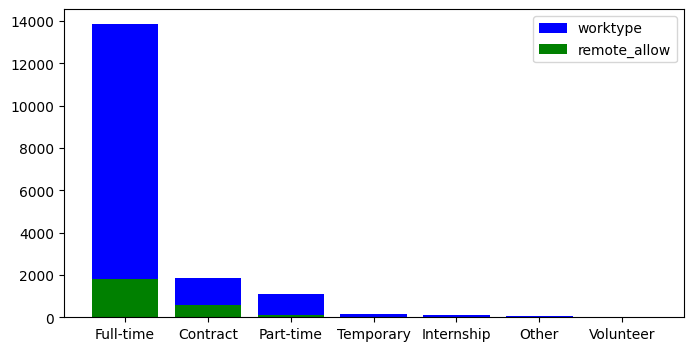

In [63]:
# построение поля для графиков 
fig, ax = plt.subplots(figsize=(8,4))

# подсчет вакансий по формату работы и возможности удаленной работы
worktype = job_post.groupby('formatted_work_type')['job_id'].count().sort_values(ascending=False).head(10)
worktype_remote = job_post[job_post['remote_allowed']==1].groupby('formatted_work_type')['job_id'].count().sort_values(ascending=False).head(10)
perc = round(worktype_remote*100/worktype,2)
worktype.name = 'Вакансий всего'
worktype_remote.name = 'Вакансий с удалёнкой'
perc.name = '%'

# настройка графиков
ax1 = plt.bar(worktype.index, worktype.values, color = 'blue')
ax2 = plt.bar(worktype_remote.index, worktype_remote.values, color = 'green')
plt.legend((ax1[0],ax2[0]), ('worktype','remote_allow'))

# объединение подсчетов в одну таблицу
union_WT_RA = pd.concat([worktype, worktype_remote, perc],axis=1)
print(union_WT_RA)